<a href="https://colab.research.google.com/github/milanfx/DTSA-5511/blob/main/Cassava_Leaf_Disease_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="font-family:Roboto Condensed SemiBold; font-size:150%; letter-spacing: 0px; background-color:darkgreen; color:#f8f2e4; text-align:center; padding-top:10px; padding-bottom:10px; border: 5px solid #f8f2e4; border-radius: 20px;"><h1><b>
Cassava Leaf Disease Classification Project
</b></h1></div>

---

<div style="text-align:center">
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*YFCXrUhiam2uR2JuMooPGw.png" alt="image description" width="800" height="300">
</div>


<div style="font-family:Roboto Condensed SemiBold; font-size:130%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:3px; padding-bottom:3px; border: 3px solid darkgreen; border-radius: 20px;">

## **1. Project Introduction**

</div>

---

### **1.1 Background**

### **1.2 Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from glob import glob

import warnings

RANDOM_STATE = 1
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle competitions download -c cassava-leaf-disease-classification
!unzip -q histopathologic-cancer-detection.zip -d dataset

100% 5.76G/5.76G [03:59<00:00, 28.2MB/s]
100% 5.76G/5.76G [03:59<00:00, 25.9MB/s]
unzip:  cannot find or open histopathologic-cancer-detection.zip, histopathologic-cancer-detection.zip.zip or histopathologic-cancer-detection.zip.ZIP.


In [ ]:
train_path = 'dataset/train/'
test_path = 'dataset/test/'

train_image = glob(os.path.join(train_path, '*.tif'))
test_image = glob(os.path.join(test_path, '*.tif'))

print(f'Number of images in train: {len(train_image)}')
print(f'Number of images in test: {len(test_image)}')

Number of images in train: 220025
Number of images in test: 57458


<div style="font-family:Roboto Condensed SemiBold; font-size:130%; letter-spacing: 0px; background-color:#f8f2e4; color:darkred; text-align:center; padding-top:3px; padding-bottom:3px; border: 3px solid darkred; border-radius: 20px;">

## **2. Exploratory Analysis**

</div>

---

### **2.1 Sample Distribution**

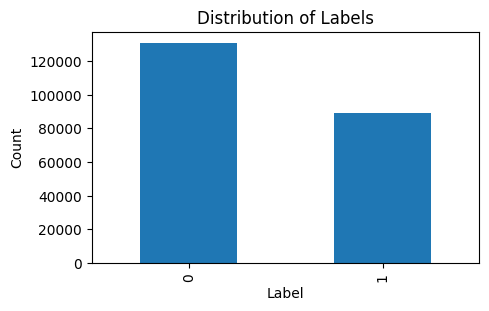

In [ ]:
labels_path = 'dataset/train_labels.csv'
train_data = pd.read_csv(labels_path)

plt.figure(figsize=(5, 3))
train_data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
train_data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

### **2.2 Positive Samples**

In [ ]:
positive_train_file_name = train_data[train_data['label'] == 1]['id']
negative_train_file_name = train_data[train_data['label'] == 0]['id']

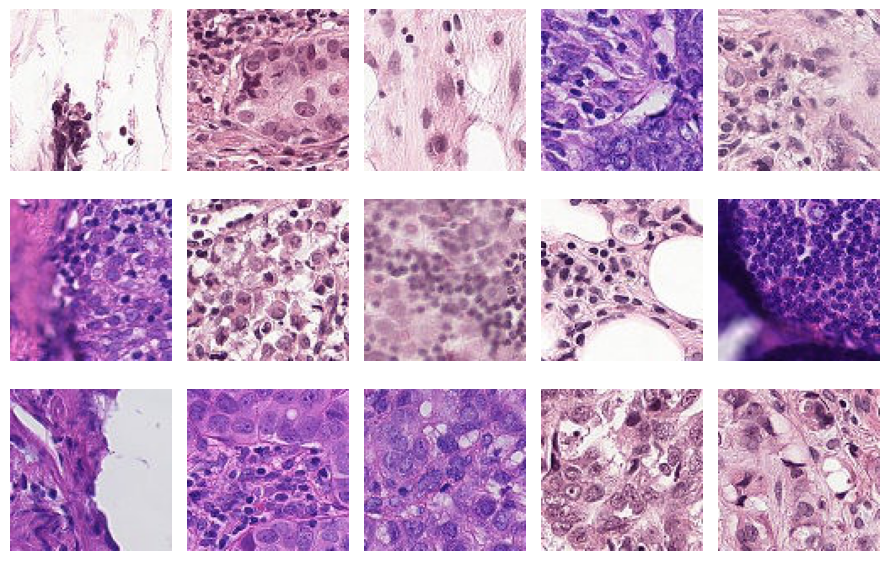

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

count = 1
for index, name in enumerate(positive_train_file_name.head(15)):
    file_name = os.path.join(train_path, f"{name}.tif")
    img = Image.open(file_name)
    ax = plt.subplot(3, 5, count)
    ax.imshow(np.array(img))
    ax.axis('off')
    count += 1
plt.tight_layout()
plt.show()

### **2.3 Negative Samples**

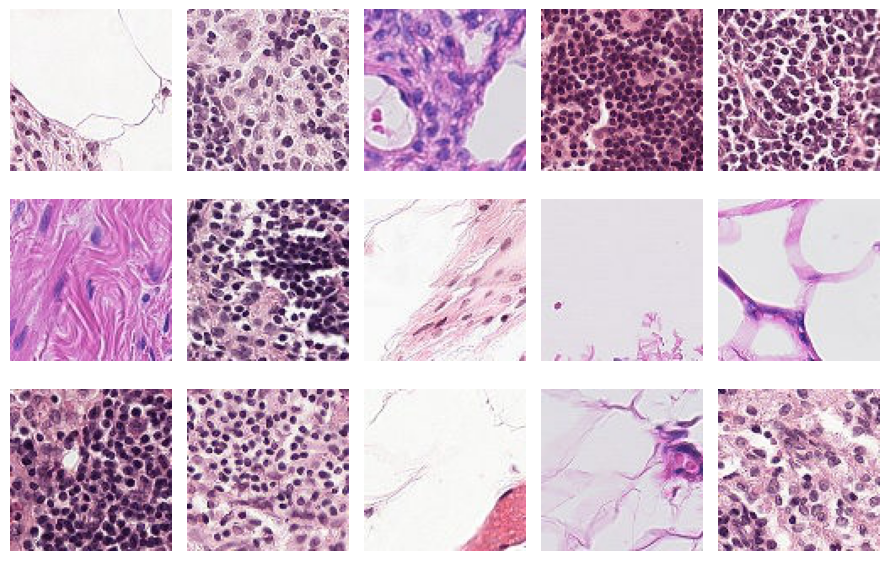

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

count = 1
for index, name in enumerate(negative_train_file_name.head(15)):
    file_name = os.path.join(train_path, f"{name}.tif")
    img = Image.open(file_name)
    ax = plt.subplot(3, 5, count)
    ax.imshow(np.array(img))
    ax.axis('off')
    count += 1
plt.tight_layout()
plt.show()

<div style="font-family:Roboto Condensed SemiBold; font-size:130%; letter-spacing: 0px; background-color:#f8f2e4; color:darkred; text-align:center; padding-top:3px; padding-bottom:3px; border: 3px solid darkred; border-radius: 20px;">

## **3. Model Architecture**

</div>

---

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle


### **3.1 Split Train and Validation**

In [ ]:
from sklearn.utils import shuffle  # 确保已经导入shuffle函数

# 定义RANDOM_STATE常量
RANDOM_STATE = 1

# 修改append_tif函数以避免重复添加后缀
def append_tif(string):
    if not string.endswith(".tif"):
        return string + ".tif"
    return string

# 应用append_tif函数并转换标签类型为字符串
train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# 随机打乱训练数据
train_data = shuffle(train_data, random_state=RANDOM_STATE)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=1,
    class_mode="binary",
    target_size=(96,96))

Found 176020 validated image filenames belonging to 2 classes.


In [ ]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=1,
    class_mode="binary",
    target_size=(96,96))       # original image = (96, 96)

Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 定义模型架构
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(rate=0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1, restore_best_weights=True)

model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
5501/5501 [==============================] - 161s 28ms/step - loss: 0.4127 - accuracy: 0.8167 - val_loss: 0.3243 - val_accuracy: 0.8646
Epoch 2/20
5501/5501 [==============================] - 149s 27ms/step - loss: 0.3174 - accuracy: 0.8676 - val_loss: 0.2932 - val_accuracy: 0.8791
Epoch 3/20
5501/5501 [==============================] - 149s 27ms/step - loss: 0.2839 - accuracy: 0.8838 - val_loss: 0.2653 - val_accuracy: 0.8931
Epoch 4/20
5501/5501 [==============================] - 146s 27ms/step - loss: 0.2608 - accuracy: 0.8936 - val_loss: 0.2537 - val_accuracy: 0.8968
Epoch 5/20
5501/5501 [==============================] - 149s 27ms/step - loss: 0.2447 - accuracy: 0.9003 - val_loss: 0.2480 - val_accuracy: 0.9012
Epoch 6/20
5501/5501 [==============================] - 148s 27ms/step - loss: 0.2305 - accuracy: 0.9072 - val_loss: 0.2378 - val_accuracy: 0.9045
Epoch 7/20
5501/5501 [==============================] - 148s 27ms/step - loss: 0.2165 - accuracy: 0.9138 - val_loss: 0

In [ ]:
sub_path = 'dataset/sample_submission.csv'
test_data = pd.read_csv(sub_path)
test_data['filename'] = test_data.id + '.tif'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col="filename",
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    batch_size=32,
    shuffle=False
)

Found 57458 validated image filenames.


In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator))
predictions = predictions.flatten()
#predicted_labels = (predictions > 0.5).astype(int).flatten()

result = pd.DataFrame({
    "id": test_data['id'],
    "label": predictions
})
result.to_csv('test6.csv', index=False)

1796/1796 [==============================] - 38s 21ms/step


0.88

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model2 = Sequential([
    # 第一层卷积块
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    Conv2D(32, (3, 3), use_bias=False), BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 第二层卷积块
    Conv2D(64, (3, 3), use_bias=False), BatchNormalization(), Activation('relu'),
    Conv2D(64, (3, 3), use_bias=False), BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 第三层卷积块
    Conv2D(128, (3, 3), use_bias=False), BatchNormalization(), Activation('relu'),
    Conv2D(128, (3, 3), use_bias=False), BatchNormalization(), Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # 分类器部分
    Flatten(),
    Dense(256, use_bias=False), BatchNormalization(), Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=3, verbose=1, restore_best_weights=True)

model2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
5501/5501 [==============================] - 155s 28ms/step - loss: 0.3611 - accuracy: 0.8474 - val_loss: 0.5384 - val_accuracy: 0.7538
Epoch 2/20
5501/5501 [==============================] - 150s 27ms/step - loss: 0.2672 - accuracy: 0.8936 - val_loss: 0.2389 - val_accuracy: 0.9026
Epoch 3/20
5501/5501 [==============================] - 149s 27ms/step - loss: 0.2321 - accuracy: 0.9100 - val_loss: 0.2067 - val_accuracy: 0.9210
Epoch 4/20
5501/5501 [==============================] - 150s 27ms/step - loss: 0.2086 - accuracy: 0.9207 - val_loss: 0.3137 - val_accuracy: 0.8705
Epoch 5/20
5501/5501 [==============================] - 151s 27ms/step - loss: 0.1909 - accuracy: 0.9277 - val_loss: 1.7461 - val_accuracy: 0.7486
Epoch 6/20
5501/5501 [==============================] - 150s 27ms/step - loss: 0.1778 - accuracy: 0.9334 - val_loss: 0.4279 - val_accuracy: 0.8579
Epoch 7/20
5501/5501 [==============================] - 151s 27ms/step - loss: 0.1657 - accuracy: 0.9382 - val_loss: 0

In [ ]:
predictions = model2.predict(test_generator, steps=len(test_generator))
predictions = predictions.flatten()
#predicted_labels = (predictions > 0.5).astype(int).flatten()

result = pd.DataFrame({
    "id": test_data['id'],
    "label": predictions
})
result.to_csv('test7.csv', index=False)

1796/1796 [==============================] - 38s 21ms/step


#0.92

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义带数据增强的 ImageDataGenerator 实例
augmented_datagen = ImageDataGenerator(
    rescale=1./255,           # 数据归一化因子
    rotation_range=40,        # 随机旋转度数范围
    width_shift_range=0.2,    # 随机宽度偏移量
    height_shift_range=0.2,   # 随机高度偏移量
    shear_range=0.2,          # 剪切强度
    zoom_range=0.2,           # 随机缩放范围
    horizontal_flip=True,     # 随机水平翻转
    fill_mode='nearest',      # 填充新创建像素的方法
    validation_split=0.2      # 数据集分割比例为训练集80%，验证集20%
)


In [ ]:
train_generator_aug = augmented_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",  # 指定这是训练数据集
    batch_size=32,
    seed=42,
    class_mode="binary",
    target_size=(96, 96)
)


Found 176020 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator_aug = augmented_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",  # 指定这是验证数据集
    batch_size=32,
    seed=42,
    class_mode="binary",
    target_size=(96, 96)
)


Found 44005 validated image filenames belonging to 2 classes.


In [ ]:


# 定义模型架构
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(rate=0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1, restore_best_weights=True)

model2.fit(
    train_generator_aug,
    validation_data=valid_generator_aug,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
5501/5501 [==============================] - 620s 112ms/step - loss: 0.4344 - accuracy: 0.8034 - val_loss: 0.3927 - val_accuracy: 0.8235
Epoch 2/15
5501/5501 [==============================] - 610s 111ms/step - loss: 0.3634 - accuracy: 0.8435 - val_loss: 0.3359 - val_accuracy: 0.8565
Epoch 3/15
 833/5501 [===>..........................] - ETA: 6:55 - loss: 0.3433 - accuracy: 0.8535

KeyboardInterrupt: 

In [ ]:
base_model = tf.keras.applications.VGG19(
    input_shape=(96,96,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),

    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 batch_normalization_4 (Bat  (None, 3, 3, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 16)                73744     
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                      

In [ ]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose = 1
)

Epoch 1/10
5501/5501 [==============================] - 156s 28ms/step - loss: 0.4909 - accuracy: 0.7812 - auc_2: 0.8521 - val_loss: 0.4043 - val_accuracy: 0.8333 - val_auc_2: 0.9116
Epoch 2/10
5501/5501 [==============================] - 153s 28ms/step - loss: 0.4595 - accuracy: 0.8024 - auc_2: 0.8750 - val_loss: 0.3829 - val_accuracy: 0.8497 - val_auc_2: 0.9226
Epoch 3/10
5501/5501 [==============================] - 155s 28ms/step - loss: 0.4452 - accuracy: 0.8122 - auc_2: 0.8839 - val_loss: 0.3750 - val_accuracy: 0.8507 - val_auc_2: 0.9244
Epoch 4/10
5501/5501 [==============================] - 155s 28ms/step - loss: 0.4389 - accuracy: 0.8154 - auc_2: 0.8871 - val_loss: 0.3697 - val_accuracy: 0.8522 - val_auc_2: 0.9257
Epoch 5/10
5501/5501 [==============================] - 157s 29ms/step - loss: 0.4354 - accuracy: 0.8164 - auc_2: 0.8887 - val_loss: 0.3675 - val_accuracy: 0.8592 - val_auc_2: 0.9287
Epoch 6/10
5501/5501 [==============================] - 156s 28ms/step - loss: 0.4308

In [ ]:
cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # 指定额外训练的轮次数
    verbose=1
)

Epoch 1/5
5501/5501 [==============================] - 154s 28ms/step - loss: 0.4198 - accuracy: 0.8260 - auc_2: 0.8977 - val_loss: 0.3586 - val_accuracy: 0.8600 - val_auc_2: 0.9297
Epoch 2/5
5501/5501 [==============================] - 155s 28ms/step - loss: 0.4193 - accuracy: 0.8260 - auc_2: 0.8977 - val_loss: 0.3628 - val_accuracy: 0.8579 - val_auc_2: 0.9312
Epoch 3/5
5501/5501 [==============================] - 153s 28ms/step - loss: 0.4159 - accuracy: 0.8275 - auc_2: 0.8992 - val_loss: 0.3570 - val_accuracy: 0.8599 - val_auc_2: 0.9329
Epoch 4/5
5501/5501 [==============================] - 155s 28ms/step - loss: 0.4138 - accuracy: 0.8277 - auc_2: 0.8998 - val_loss: 0.3545 - val_accuracy: 0.8643 - val_auc_2: 0.9326
Epoch 5/5
5501/5501 [==============================] - 156s 28ms/step - loss: 0.4124 - accuracy: 0.8299 - auc_2: 0.9009 - val_loss: 0.3576 - val_accuracy: 0.8610 - val_auc_2: 0.9318


<div style="font-family:Roboto Condensed SemiBold; font-size:130%; letter-spacing: 0px; background-color:#f8f2e4; color:darkred; text-align:center; padding-top:3px; padding-bottom:3px; border: 3px solid darkred; border-radius: 20px;">

## **4. Results and Analysis**

</div>

---

In [ ]:
sub_path = 'dataset/sample_submission.csv'
test_data = pd.read_csv(sub_path)
test_data['filename'] = test_data.id + '.tif'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col="filename",
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    batch_size=32,
    shuffle=False
)

Found 57458 validated image filenames.


In [ ]:
predictions = model2.predict(test_generator, steps=len(test_generator))
predicted_labels = (predictions > 0.5).astype(int).flatten()

result = pd.DataFrame({
    "id": test_data['id'],
    "label": predicted_labels
})
result.to_csv('test5.csv', index=False)

1796/1796 [==============================] - 39s 22ms/step


In [ ]:
predictions = cnn.predict(test_generator, steps=len(test_generator))
predicted_labels = (predictions > 0.5).astype(int).flatten()

result = pd.DataFrame({
    "id": test_data['id'],
    "label": predicted_labels
})
result.to_csv('test3.csv', index=False)

1796/1796 [==============================] - 41s 23ms/step


<div style="font-family:Roboto Condensed SemiBold; font-size:130%; letter-spacing: 0px; background-color:#f8f2e4; color:darkred; text-align:center; padding-top:3px; padding-bottom:3px; border: 3px solid darkred; border-radius: 20px;">

## **5. Project Conclusion**

</div>

---